In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:


print(" CROSS-COUNTRY SOLAR DATA COMPARISON ")
print("Loading cleaned datasets from individual country analyses...")

 CROSS-COUNTRY SOLAR DATA COMPARISON 
Loading cleaned datasets from individual country analyses...


In [3]:
# 1. LOAD CLEANED DATASETS (From individual EDA notebooks)
try:
    benin = pd.read_csv(r'C:\Users\admin\solar-challenge-week0\data\benin-malanville_clean.csv')
    sierra_leone = pd.read_csv(r'C:\Users\admin\solar-challenge-week0\data\sierraleone-bumbuna_clean.csv')  
    togo = pd.read_csv(r'C:\Users\admin\solar-challenge-week0\data\togo-dapaong_qc_clean.csv')
    
    print("✅ All cleaned datasets loaded successfully!")
    
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Please make sure all EDA branches have been merged to main and cleaned CSVs are generated.")
    raise

✅ All cleaned datasets loaded successfully!


In [4]:
# Add country identifiers
benin['Country'] = 'Benin'
sierra_leone['Country'] = 'Sierra Leone' 
togo['Country'] = 'Togo'


In [5]:

# Convert timestamps
for df in [benin, sierra_leone, togo]:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Combine datasets
combined = pd.concat([benin, sierra_leone, togo], ignore_index=True)
combined = combined.sort_values('Timestamp')

In [6]:
print(f"\n📊 DATASET OVERVIEW:")
print(f"• Benin: {len(benin):,} records")
print(f"• Sierra Leone: {len(sierra_leone):,} records") 
print(f"• Togo: {len(togo):,} records")
print(f"• Combined: {len(combined):,} total records")
print(f"• Date range: {combined['Timestamp'].min()} to {combined['Timestamp'].max()}")
print(f"• Countries: {combined['Country'].unique().tolist()}")



📊 DATASET OVERVIEW:
• Benin: 514,854 records
• Sierra Leone: 497,012 records
• Togo: 516,349 records
• Combined: 1,528,215 total records
• Date range: 2021-08-09 00:01:00 to 2022-10-30 00:00:00
• Countries: ['Benin', 'Togo', 'Sierra Leone']


In [7]:
print("1. SUMMARY STATISTICS BY COUNTRY")

key_metrics = [col for col in ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'PW', 'RH'] if col in df.columns]

# Create comprehensive summary table
summary_stats = combined.groupby('Country')[key_metrics].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("Summary Statistics Table:")
print(summary_stats)


1. SUMMARY STATISTICS BY COUNTRY
Summary Statistics Table:
                 GHI                                          DNI          \
               count    mean median     std   min     max   count    mean   
Country                                                                     
Benin         514854  233.69    0.2  326.82 -11.1  1214.0  514854  166.28   
Sierra Leone  497012  171.05   -0.5  264.09 -15.9  1022.0  497012   92.76   
Togo          516349  223.86    0.5  317.31 -12.7  1198.0  516349  147.98   

                             ...     WS                      RH                \
             median     std  ... median   std  min  max   count   mean median   
Country                      ...                                                
Benin          -0.2  262.05  ...    1.9  1.49  0.0  6.5  514854  54.66   55.2   
Sierra Leone   -0.1  184.79  ...    0.7  1.13  0.0  4.5  497012  80.18   86.7   
Togo            0.0  247.68  ...    2.2  1.38  0.0  6.7  516349  55.18   

In [11]:

# Save summary table
summary_stats.to_csv(r'C:/Users/admin/solar-challenge-week0/data/cross_country_summary.csv')
print("✅ Summary statistics saved to: ../data/processed/cross_country_summary.csv")

✅ Summary statistics saved to: ../data/processed/cross_country_summary.csv


2. DISTRIBUTION COMPARISON - BOXPLOTS


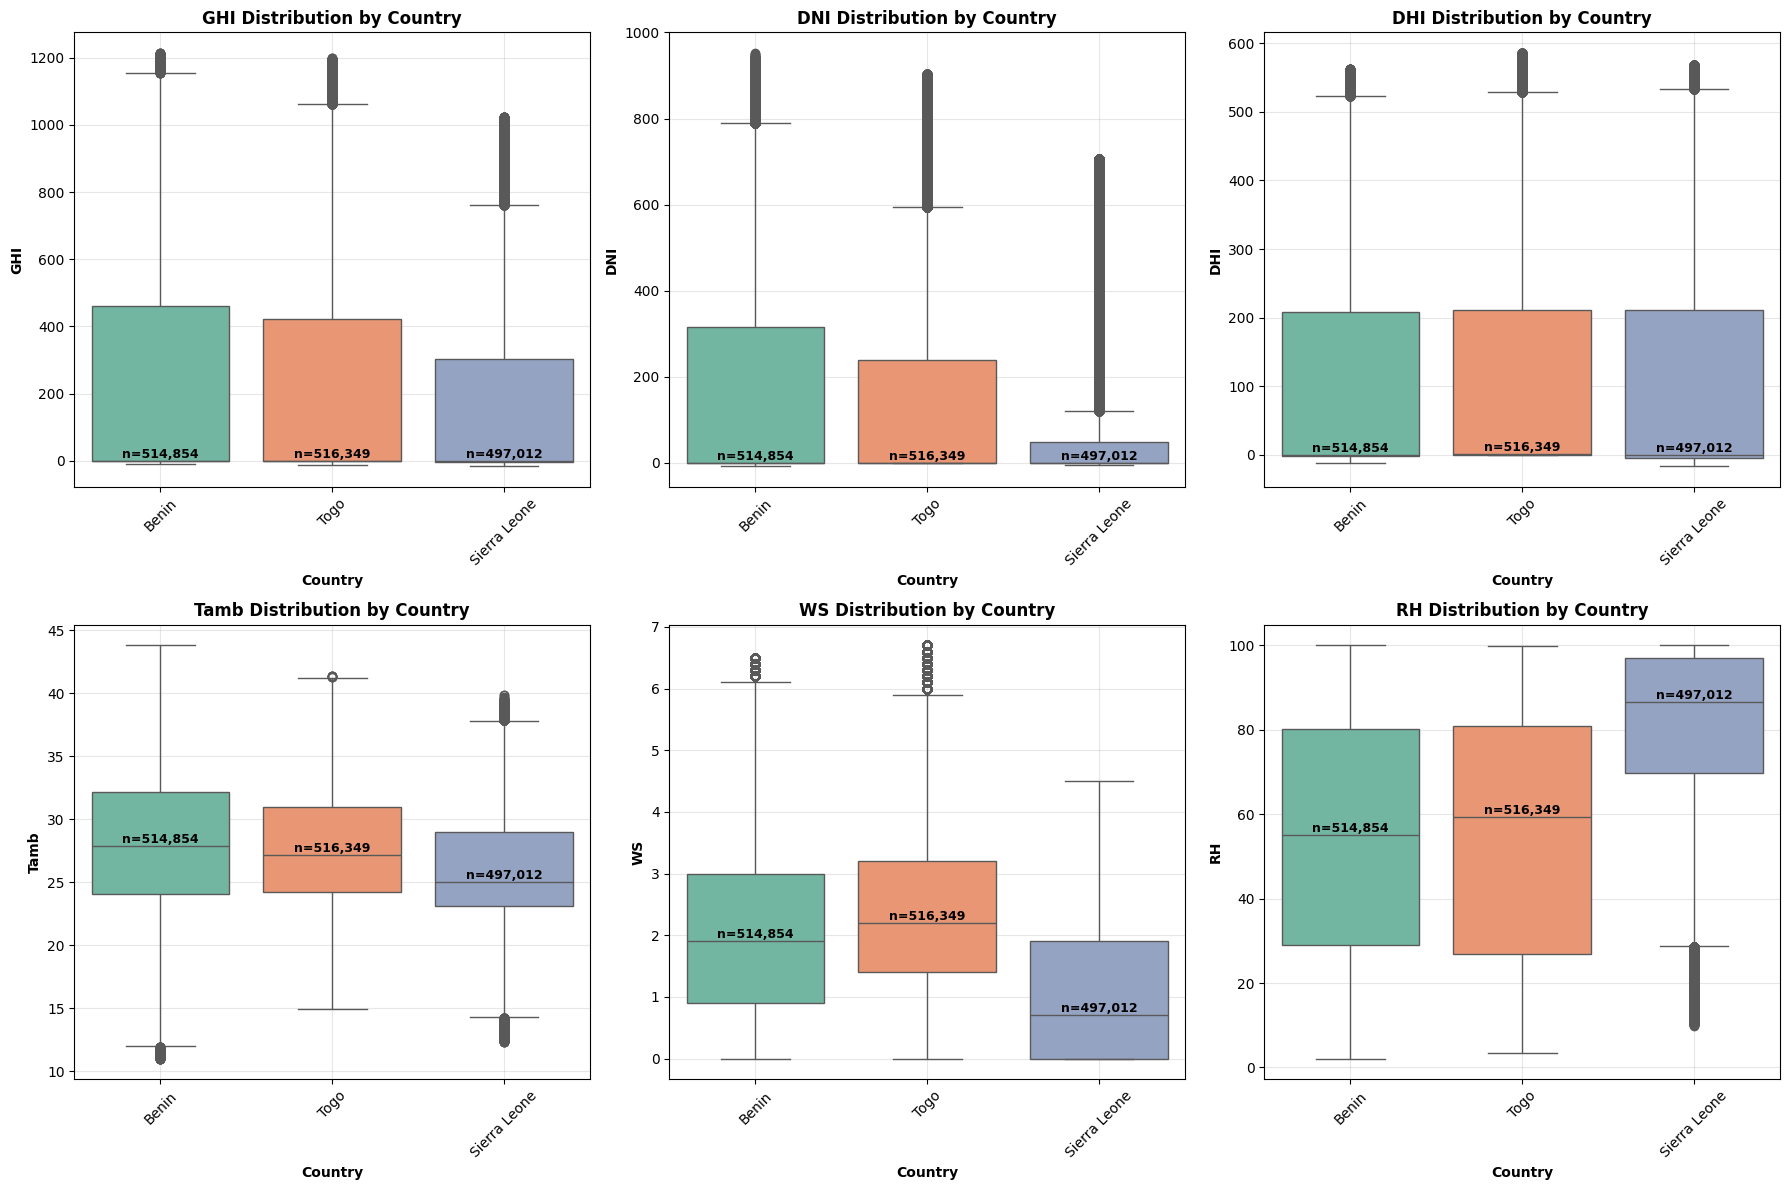

In [12]:
print("2. DISTRIBUTION COMPARISON - BOXPLOTS")

# Create boxplots for key solar metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

solar_metrics = ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'RH']

for i, metric in enumerate(solar_metrics):
    sns.boxplot(data=combined, x='Country', y=metric, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{metric} Distribution by Country', fontweight='bold', fontsize=12)
    axes[i].set_xlabel('Country', fontweight='bold')
    axes[i].set_ylabel(metric, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    
    # Add sample size annotations
    countries = combined['Country'].unique()
    for j, country in enumerate(countries):
        country_data = combined[combined['Country'] == country][metric].dropna()
        if len(country_data) > 0:
            axes[i].text(j, country_data.median(), f'n={len(country_data):,}', 
                        ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()


In [13]:
print("3. STATISTICAL SIGNIFICANCE TESTING")

print("HYPOTHESIS TESTING: Differences in Solar Metrics Between Countries")
print("Method: ANOVA for normal distributions, Kruskal-Wallis for non-normal")
print("Significance level: α = 0.05\n")


3. STATISTICAL SIGNIFICANCE TESTING
HYPOTHESIS TESTING: Differences in Solar Metrics Between Countries
Method: ANOVA for normal distributions, Kruskal-Wallis for non-normal
Significance level: α = 0.05



In [18]:
for metric in ['GHI', 'DNI', 'DHI', 'Tamb']:
    print(f"\n--- {metric} ---")
    
    # Prepare country groups
    country_groups = []
    country_names = []
    
    for country in combined['Country'].unique():
        country_data = combined[combined['Country'] == country][metric].dropna()
        if len(country_data) > 0:
            country_groups.append(country_data)
            country_names.append(country)
    
    if len(country_groups) >= 2:
        # Test for normality
        normal_distributed = True
        for i, group in enumerate(country_groups):
            if len(group) > 3 and len(group) < 5000:
                _, p_value = stats.shapiro(group)
                if p_value < 0.05:
                    normal_distributed = False
                    break
        
        # Perform appropriate test
        if normal_distributed:
            f_stat, p_value = stats.f_oneway(*country_groups)
            test_used = "ANOVA"
            print(f"Test used: {test_used} (data is normally distributed)")
            print(f"F-statistic: {f_stat:.4f}")
        else:
            h_stat, p_value = stats.kruskal(*country_groups)
            test_used = "Kruskal-Wallis"
            print(f"Test used: {test_used} (data is not normally distributed)")
            print(f"H-statistic: {h_stat:.4f}")
        
        print(f"P-value: {p_value:.6f}")
        
        # Interpretation
        if p_value < 0.05:
            print("✅ **STATISTICALLY SIGNIFICANT**: There are significant differences between countries (p < 0.05)")
        else:
            print("❌ **NOT SIGNIFICANT**: No statistically significant differences found (p ≥ 0.05)")
    else:
        print("Insufficient data for statistical testing")




--- GHI ---
Test used: ANOVA (data is normally distributed)
F-statistic: 6162.1287
P-value: 0.000000
✅ **STATISTICALLY SIGNIFICANT**: There are significant differences between countries (p < 0.05)

--- DNI ---
Test used: ANOVA (data is normally distributed)
F-statistic: 13419.5222
P-value: 0.000000
✅ **STATISTICALLY SIGNIFICANT**: There are significant differences between countries (p < 0.05)

--- DHI ---
Test used: ANOVA (data is normally distributed)
F-statistic: 435.9816
P-value: 0.000000
✅ **STATISTICALLY SIGNIFICANT**: There are significant differences between countries (p < 0.05)

--- Tamb ---
Test used: ANOVA (data is normally distributed)
F-statistic: 22617.8894
P-value: 0.000000
✅ **STATISTICALLY SIGNIFICANT**: There are significant differences between countries (p < 0.05)


4. TIME SERIES COMPARISON


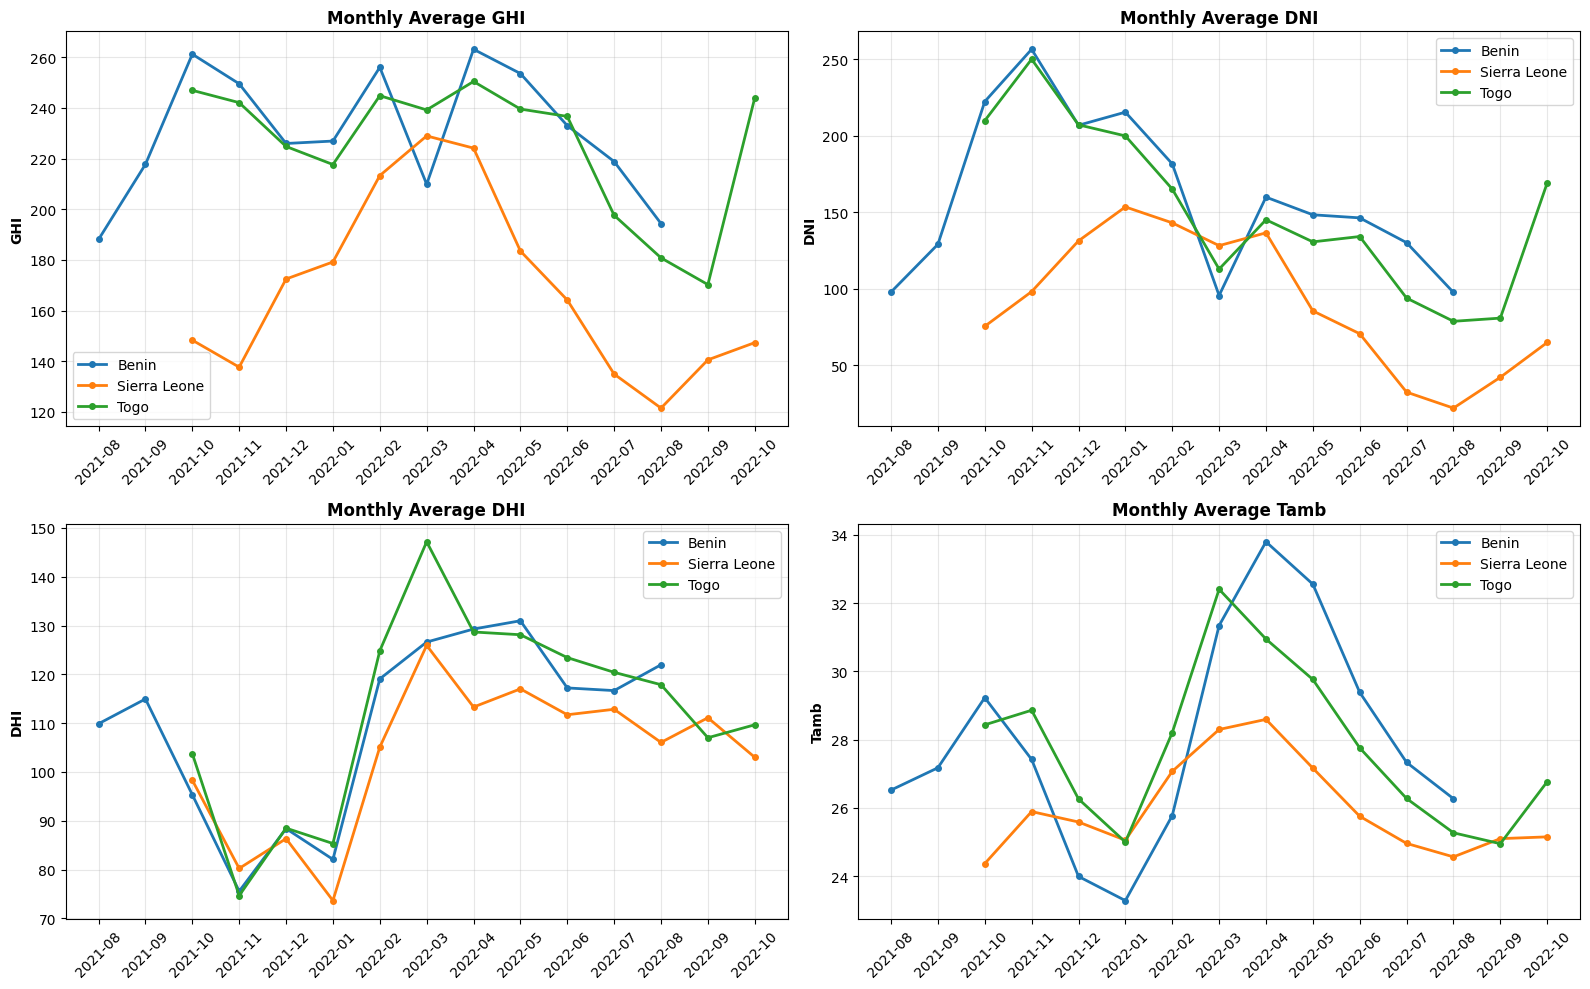

In [19]:
print("4. TIME SERIES COMPARISON")

# Monthly aggregation for trend analysis
combined['YearMonth'] = combined['Timestamp'].dt.to_period('M')
monthly_avg = combined.groupby(['Country', 'YearMonth'])[key_metrics].mean().reset_index()
monthly_avg['YearMonth'] = monthly_avg['YearMonth'].astype(str)

# Plot monthly trends for key metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

trend_metrics = ['GHI', 'DNI', 'DHI', 'Tamb']

for i, metric in enumerate(trend_metrics):
    for country in monthly_avg['Country'].unique():
        country_data = monthly_avg[monthly_avg['Country'] == country]
        # FIX: Change 'countly_data' to 'country_data'
        axes[i].plot(country_data['YearMonth'], country_data[metric], 
                    marker='o', label=country, linewidth=2, markersize=4)
    
    axes[i].set_title(f'Monthly Average {metric}', fontweight='bold', fontsize=12)
    axes[i].set_ylabel(metric, fontweight='bold')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

5. CORRELATION COMPARISON


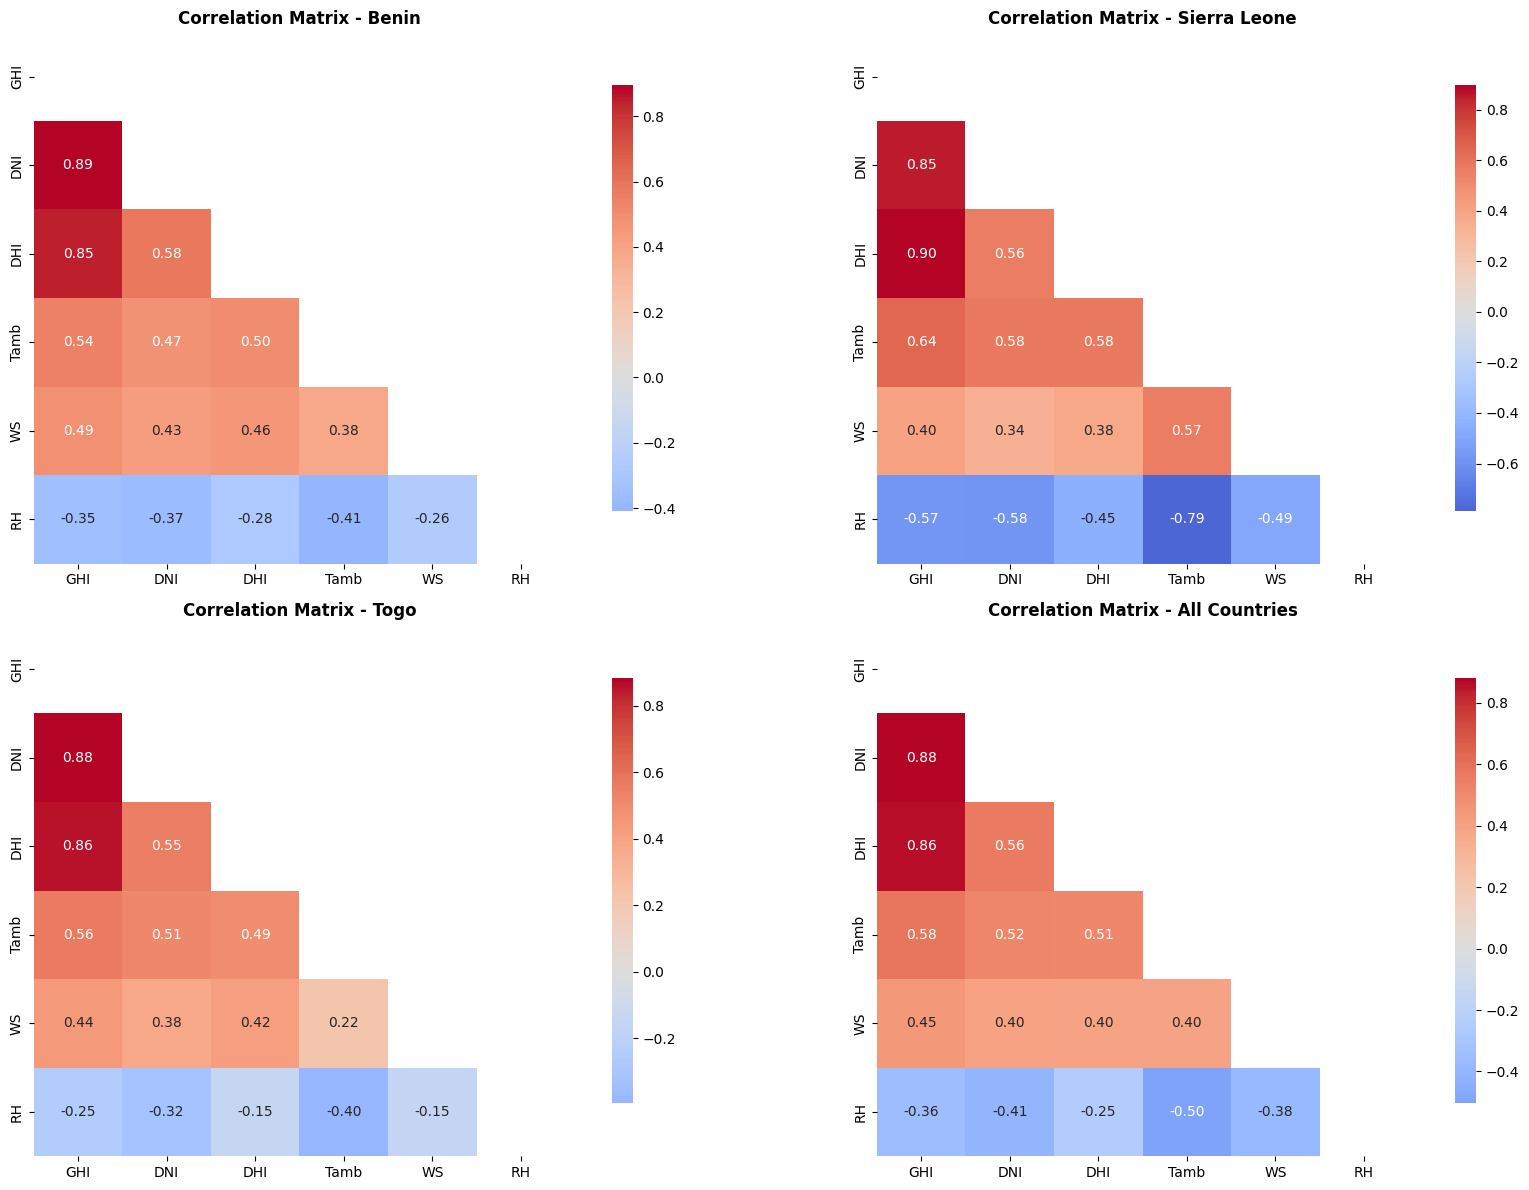

In [20]:
print("5. CORRELATION COMPARISON")

# Create correlation matrices for each country
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

countries = ['Benin', 'Sierra Leone', 'Togo']
correlation_metrics = ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'RH']

for i, country in enumerate(countries):
    country_data = combined[combined['Country'] == country][correlation_metrics]
    corr_matrix = country_data.corr()
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, fmt='.2f', square=True, ax=axes[i],
                cbar_kws={"shrink": .8})
    axes[i].set_title(f'Correlation Matrix - {country}', fontweight='bold', fontsize=12)

# Overall correlation
corr_matrix_all = combined[correlation_metrics].corr()
mask = np.triu(np.ones_like(corr_matrix_all, dtype=bool))
sns.heatmap(corr_matrix_all, mask=mask, annot=True, cmap='coolwarm', 
            center=0, fmt='.2f', square=True, ax=axes[3],
            cbar_kws={"shrink": .8})
axes[3].set_title('Correlation Matrix - All Countries', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()


In [21]:
print("6. KEY INSIGHTS AND OBSERVATIONS")

print("\n📊 SOLAR POTENTIAL RANKINGS:")
for metric in ['GHI', 'DNI', 'DHI']:
    ranking = combined.groupby('Country')[metric].mean().sort_values(ascending=False)
    print(f"\n{metric} Ranking (Highest to Lowest):")
    for country, value in ranking.items():
        print(f"  • {country}: {value:.2f} W/m²")

print("\n🌡️ TEMPERATURE ANALYSIS:")
temp_stats = combined.groupby('Country')['Tamb'].agg(['mean', 'std']).round(1)
for country in temp_stats.index:
    stats = temp_stats.loc[country]
    print(f"  • {country}: {stats['mean']}°C (±{stats['std']}°C)")

print("\n💨 WIND CONDITIONS:")
wind_stats = combined.groupby('Country')['WS'].agg(['mean', 'max']).round(2)
for country in wind_stats.index:
    stats = wind_stats.loc[country]
    print(f"  • {country}: Average {stats['mean']} m/s, Maximum {stats['max']} m/s")

print("\n📈 DATA QUALITY SUMMARY:")
for country in combined['Country'].unique():
    country_data = combined[combined['Country'] == country]
    complete_cases = country_data[key_metrics].dropna()
    print(f"  • {country}: {len(complete_cases):,} complete records ({(len(complete_cases)/len(country_data))*100:.1f}% data completeness)")


6. KEY INSIGHTS AND OBSERVATIONS

📊 SOLAR POTENTIAL RANKINGS:

GHI Ranking (Highest to Lowest):
  • Benin: 233.69 W/m²
  • Togo: 223.86 W/m²
  • Sierra Leone: 171.05 W/m²

DNI Ranking (Highest to Lowest):
  • Benin: 166.28 W/m²
  • Togo: 147.98 W/m²
  • Sierra Leone: 92.76 W/m²

DHI Ranking (Highest to Lowest):
  • Togo: 112.78 W/m²
  • Benin: 108.82 W/m²
  • Sierra Leone: 103.94 W/m²

🌡️ TEMPERATURE ANALYSIS:
  • Benin: 28.1°C (±5.9°C)
  • Sierra Leone: 26.1°C (±4.4°C)
  • Togo: 27.7°C (±4.8°C)

💨 WIND CONDITIONS:
  • Benin: Average 2.05 m/s, Maximum 6.5 m/s
  • Sierra Leone: Average 1.06 m/s, Maximum 4.5 m/s
  • Togo: Average 2.31 m/s, Maximum 6.7 m/s

📈 DATA QUALITY SUMMARY:
  • Benin: 514,854 complete records (100.0% data completeness)
  • Togo: 516,349 complete records (100.0% data completeness)
  • Sierra Leone: 497,012 complete records (100.0% data completeness)


In [22]:
print("CROSS-COUNTRY ANALYSIS COMPLETE")
print("Key files generated:")
print("• ../data\cross_country_summary.csv")
print("• Visualizations and statistical tests completed")

CROSS-COUNTRY ANALYSIS COMPLETE
Key files generated:
• ../data\cross_country_summary.csv
• Visualizations and statistical tests completed
